In [7]:
import sys
kaggle_path = ['../Data/Kaggle/train/*']
sys.path.append('../')
from First_start.imports import *
from First_start.multi_gpu import *
from First_start.init_vars import *
from First_start.start_functions import *
%load_ext autoreload
%autoreload 2

Imports imported
multi_gpu imported
Vars initialized (FISH_DICTS, seed)


In [6]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import pandas as pd

model = ResNet50(weights='imagenet')

afmetingen = [(0,0.5,0,0.5),(0.5,1,0,0.5),(0.5,1,0.5,1),(0,0.5,0.5,1)]

In [2]:
import math
%matplotlib inline

In [3]:
def get_xy(folders_paths=['../Data/Kaggle/train/*', '../Data/Imagenet/*'],
           test_size=0.0, img_size=(224, 224), seed=7):
    """Retrieves all data from a folders_path and gives back
    x_train, x_test, y_train, y_test
    folders_path: The folder to the data (standard: '../Data/Kaggle/train/*')
    img_size: size of the image (standard: (224, 224))
    split: Where to make the split between training and test data
    """
    # creating a dataframe with the columns below
    image_dict = {}

    # going through all folders and saving file names in dataframe so that order is always correct
    for folders_path in folders_paths:
        for foldername in glob.glob(folders_path):
            for image_name in glob.glob(foldername + '/*.jpg'):
                # getting image name and fish type and putting it in a dictionary
                fish_type = foldername.split('/')[-1]
                image_dict[image_name] = fish_type
            
        assert image_dict, 'Files not found in {}'.format(folders_path)

    # image_df: image_name | fish_type
    # NOTE: Change sampling back to 1 once model is done
    image_df = pd.DataFrame({'image': list(image_dict.keys()), 'fish_type': list(image_dict.values())}).sample(frac=0.05)   
    
    # dummy_df: dummy version of image_df
    dummy_df = pd.get_dummies(image_df, columns=['fish_type']) # dummify data
    
    # Create list with images as arrays
    images = np.array([cv2.imread(img) for img in dummy_df.image])   
    images = [cv2.resize(img, img_size, cv2.INTER_LINEAR) for img in images]

    # X and y value and labels
    x = images
    y = dummy_df.iloc[:,1:9].as_matrix()

    # Split dataset
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)
    
    x_train, x_test, y_train, y_test = np.asarray(x_train), np.asarray(x_test), np.asarray(y_train), np.asarray(y_test)
    
    
    # Return stuff
    return x_train, y_train, x_test, y_test, image_df, dummy_df


def get_final_test(files_path='../Data/Kaggle/test1/*.jpg', img_size=(224, 224)):
    """Gets final test data
    """
    # going through all folders and saving file names in list so that order is always correct
    x_test_names = glob.glob(files_path)
    x_test = np.asarray([cv2.resize(cv2.imread(name), (224, 224), cv2.INTER_LINEAR) for name in x_test_names])
    
    # Return stuff
    return x_test_names, x_test

In [14]:
# Get x and y variables
test_size = (448, 448)
x_train, y_train, x_test, y_test, image_df, dummy_df = get_xy(folders_paths=kaggle_path, test_size=0.3,
                                                              img_size=test_size, seed=seed)

# Let's check the shape of those variables
print (x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(132, 448, 448, 3) (132, 8) (57, 448, 448, 3) (57, 8)


In [15]:
def sliding_window(image, stepSize, windowSize):
    """
    Slide a windows across the image to find a image with mostly fish
    """

    # slide a window across the image

    for y in xrange(0, image.shape[0], stepSize):

        for x in xrange(0, image.shape[1], stepSize):

            # yield the current window

            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [16]:
def long_slice(image, slice_size):
    """
    
    """
    slices = int(image.shape[0]/slice_size) * 2 - 1
    step_size = int(slice_size/2.0)
    for hor_ind in range(slices):
        for ver_ind in range(slices):
            print(hor_ind*step_size,hor_ind*step_size+slice_size, ver_ind*step_size,ver_ind*step_size+slice_size)
            current_slice = image[hor_ind*step_size:hor_ind*step_size+slice_size,
                                  ver_ind*step_size:ver_ind*step_size+slice_size,:]
            current_slice = cv2.resize(current_slice, (224, 224), cv2.INTER_LINEAR)
            plt.imshow(current_slice);
            plt.show();

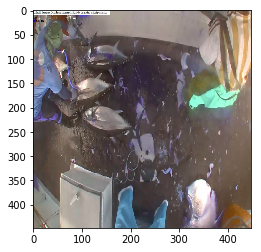

In [17]:
plt.imshow(x_train[0,:,:,:]);

In [3]:
#long_slice(x_train[0,:,:,:], 224)

In [ ]:
outcome = []
for i in range(x_train.shape[0]):
    window_sizes = (56,112,224)
    for size in window_sizes:
        long_slice(x_train[i,:,:,:], size)
    suboutcome = []
    for image_name in glob.glob('test/*.png'):
    #for i in range(4):
        #afmeting = afmetingen[i]
         #   print img.size
        img = image.load_img(image_name, target_size=(224, 224))
        x = image.img_to_array(img)
        
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
        suboutcome.append((img,decode_predictions(preds, top=10)[0]))
    outcome.append(suboutcome)
for suboutcome in outcome:
    for subimage in suboutcome:
        plt.imshow(subimage[0])
        plt.show()
        print subimage[1]   
# Predicted: [(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tusker', 0.1122357), (u'n02504458', u'African_elephant', 0.061040461)]

In [8]:
is_a_df = pd.read_csv('./is_a.csv',delimiter=' ',header=None)
is_a_df.columns = ['parent','child']

fish_labels = []

def findChildrenFish(df,parent):
    children = is_a_df[is_a_df['parent'] == parent].child
    #print children
    if children.shape[0]== 0:
        return None
    else:
        return children.tolist()

fish = 'n02512053'
children = is_a_df[is_a_df['parent'] == fish].child
fish_labels.append(children.tolist())
    
    

In [10]:
len(fish_labels)

1